In [1]:
import numpy as np
import pandas as pd
import json as json
from scipy import stats
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
from o_plot import opl # a small local package dedicated to this project

In [3]:
# Prepare the data

In [4]:
# loading the data
file_name = 'Up_to_Belem_TE4AL2_data_new.json'
f = open(file_name)
All_data = json.load(f)
print(len(All_data))

146


## Note for the interpretation of the curves and definition of the statistical variables

The quantum state classifier (QSC) error rates $\widehat{r}_i$ in function of the number of experimental shots $n$ were determined for each highly entangled quantum state $\omega_i$ in the $\Omega$ set, with $i=1...m$.

The curves seen on the figures represents the mean of the QSC error rate $\widehat{r}_{mean}$ over the $m$ quantum states at each $n$ value.

This Monte Carlo simulation allowed to determine a safe shot number $n_s$ such that $\forall i\; \widehat{r}_i\le \epsilon_s$. The value of $\epsilon_s$ was set at 0.001.

$\widehat{r}_{max}$ is the maximal value observed among all the $\widehat{r}_i$ values for the determined  number of shots $n_s$.

Similarly, from the error curves stored in the data file, was computed the safe shot number $n_t$ such that $\widehat{r}_{mean}\le \epsilon_t$. The value of $\epsilon_t$ was set at 0.0005 after verifying that all $\widehat{r}_{mean}$ at $n_s$ were $\le \epsilon_s$ in the different experimental settings. 

Correspondance between variables names in the text and in the data base:

- $\widehat{r}_{mean}$: error_curve
- $n_s$: shots
- max ($\widehat{r}_i$) at $n_s$: shot_rate
- $\widehat{r}_{mean}$ at $n_s$: mns_rate
- $n_t$: m_shots
- $\widehat{r}_{mean}$ at $n_t$: m_shot_rate




In [5]:
# Calculate shot number 'm_shots' for mean error rate 'm_shot_rates' <= epsilon_t
len_data = len(All_data)
epsilon_t = 0.0005
window = 11
for i in range(len_data):            
    curve = np.array(All_data[i]['error_curve'])
    # filter the curve only for real devices:
    if All_data[i]['device']!="ideal_device":    
        curve = savgol_filter(curve,window,2) 
    # find the safe shot number:    
    len_c = len(curve)                               
    n_a = np.argmin(np.flip(curve)<=epsilon_t)+1                          
    if n_a == 1:
        n_a = np.nan
        m_r = np.nan
    else:
        m_r = curve[len_c-n_a+1]
    All_data[i]['min_r_shots'] = len_c-n_a
    All_data[i]['min_r'] = m_r

In [6]:
# find mean error rate at n_s
for i in range(len_data):
    i_shot = All_data[i]["shots"]
    if not np.isnan(i_shot):
        j = int(i_shot)-1        
        All_data[i]['mns_rate'] = All_data[i]['error_curve'][j]
    else:
        All_data[i]['mns_rate'] = np.nan

In [7]:
#defining the pandas data frame for statistics
df_All= pd.DataFrame(All_data,columns=['shot_rates','shots', 'device', 'fidelity',
                                        'mitigation','model','id_gates',
                                        'QV', 'metric','error_curve',
                                        'mns_rate','min_r_shots','min_r'])

# any shot number >= 488 indicates that the curve calculation 
# was ended after reaching n = 500, hence this data correction:
df_All.loc[df_All.shots>=488,"shots"]=np.nan

# add the variable neperian log of safe shot number: 
df_All['log_shots'] = np.log(df_All['shots'])
df_All['log_min_r_shots'] = np.log(df_All['min_r_shots'])

### Error rates in function of chosen $\epsilon_s$ and $\epsilon_t$

In [8]:
print("max mean error rate at n_s over all experiments =", round(max(df_All.mns_rate[:-2]),6), "vs epsilon_a =", epsilon_t)

max mean error rate at n_s over all experiments = 0.000515 vs epsilon_a = 0.0005


In [9]:
print("min mean error rate at n_t over all experiments =", round(min(df_All.min_r[:-2]),6), "vs epsilon_a =", epsilon_t)

min mean error rate at n_t over all experiments = 0.000386 vs epsilon_a = 0.0005


In [10]:
print("max mean error rate at n_t over all experiments =", round(max(df_All.min_r[:-2]),6), "vs epsilon_a =", epsilon_t)

max mean error rate at n_t over all experiments = 0.0005 vs epsilon_a = 0.0005


<AxesSubplot:ylabel='Frequency'>

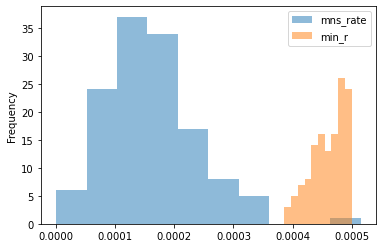

In [11]:
df_All.mns_rate[:-2].plot.hist(alpha=0.5, legend = True)
df_All.min_r[:-2].plot.hist(alpha=0.5, legend = True)

#### Comment:
- Histogram to the left: the observed $\widehat{r}_{mean}$ at $n_s$ is always less than 0.0006 for $\epsilon_s$ set at 0.001, and this for all tested experimental settings. 
- Histogram to the right: the $\widehat{r}_{mean}$ distribution is included in the 0.00038-0.0005 error rate interval when $\epsilon_t$ is set at 0.0005. 

# Statistical overview

For this section, an ordinary linear least square estimation is performed.
The dependent variables tested are $ln\;n_s$ (log_shots) and $ln\;n_t$ (log_min_r_shots)

In [12]:
stat_model = ols("log_shots ~  metric",
                 df_All).fit()
print(stat_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_shots   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                 1.247e-07
Date:                Sun, 28 Feb 2021   Prob (F-statistic):               1.00
Time:                        08:31:37   Log-Likelihood:                -118.60
No. Observations:                 134   AIC:                             241.2
Df Residuals:                     132   BIC:                             247.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.91

In [13]:
stat_model = ols("log_min_r_shots ~  metric",
                 df_All).fit()
print(stat_model.summary())

                            OLS Regression Results                            
Dep. Variable:        log_min_r_shots   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                 0.0003681
Date:                Sun, 28 Feb 2021   Prob (F-statistic):              0.985
Time:                        08:31:37   Log-Likelihood:                -116.53
No. Observations:                 134   AIC:                             237.1
Df Residuals:                     132   BIC:                             242.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.69

In [14]:
stat_model = ols("log_shots ~  model+mitigation+id_gates+device",
                 df_All.query("device != 'ideal_device' & metric == 'sqeuclidean'")).fit()
print(stat_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_shots   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     25.50
Date:                Sun, 28 Feb 2021   Prob (F-statistic):           1.57e-17
Time:                        08:31:37   Log-Likelihood:                 3.1385
No. Observations:                  66   AIC:                             17.72
Df Residuals:                      54   BIC:                             44.00
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [15]:
stat_model = ols("log_min_r_shots ~  model+mitigation+id_gates+device",
                 df_All.query("device != 'ideal_device'& metric == 'sqeuclidean'")).fit()
print(stat_model.summary())

                            OLS Regression Results                            
Dep. Variable:        log_min_r_shots   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     29.07
Date:                Sun, 28 Feb 2021   Prob (F-statistic):           8.55e-19
Time:                        08:31:38   Log-Likelihood:                 7.6551
No. Observations:                  66   AIC:                             8.690
Df Residuals:                      54   BIC:                             34.97
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

#### Comments:

For the QSC, two different metrics were compared and at the end they gave the same output. For further analysis, the results obtained using the squared euclidean distance between distribution will be illustrated in this notebook, as it is more classical and strictly equivalent to the other classical Hellinger and Bhattacharyya distances. The Jensen-Shannon metric has however the theoretical advantage of being bayesian in nature and is therefore presented as an option for the result analysis.

Curves obtained for counts corrected by measurement error mitigation (MEM) are used in this presentation. MEM significantly reduces $n_s$ and  $n_t$. However, using counts distribution before MEM is presented as an option because they anticipate how the method could perform in devices with more qubits where obtaining the mitigation filter is a problem. 

Introducing a delay time $\delta t$ of 256 identity gates between state creation and measurement significantly increased $ln\;n_s$ and $ln\;n_t$ . 


# Detailed statistical analysis



### Determine the options
Running sequentially these cells will end up with the main streaming options

In [16]:
# this for Jensen-Shannon metric 
s_metric = 'jensenshannon'
sm = np.array([96+16+16+16]) # added Quito and Lima and Belem
SAD=0
# ! will be unselected by running the next cell

In [17]:
# mainstream option for metric: squared euclidean distance
# skip this cell if you don't want this option
s_metric = 'sqeuclidean'
sm = np.array([97+16+16+16]) # added Quito and Lima and Belem
SAD=2   

In [18]:
# this for no mitigation
mit = 'no'
MIT=-4
# ! will be unselected by running the next cell

In [19]:
# mainstream option: this for measurement mitigation
# skip this cell if you don't want this option
mit = 'yes'
MIT=0

## 1. Compare distribution models


In [20]:
# select data according to the options
df_mod = df_All[df_All.mitigation == mit][df_All.metric == s_metric]

<ipython-input-20-af347b9ea33a>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_mod = df_All[df_All.mitigation == mit][df_All.metric == s_metric]


### A look at $n_s$ and  $n_t$

In [21]:
print("mitigation:",mit,"  metric:",s_metric )
df_mod.groupby('device')[['shots','min_r_shots']].describe(percentiles=[0.5])

mitigation: yes   metric: sqeuclidean


shots                                         min_r_shots  \
              count    mean        std    min    50%    max       count   
device                                                                    
ibmq_athens     4.0   40.75  10.078856   32.0   39.0   53.0         4.0   
ibmq_belem      4.0   39.00  15.077577   25.0   36.5   58.0         4.0   
ibmq_lima       4.0   50.50  25.722882   29.0   45.5   82.0         4.0   
ibmq_ourense    4.0   34.75   4.112988   30.0   34.5   40.0         4.0   
ibmq_quito      4.0  100.50  72.399355   39.0   79.0  205.0         4.0   
ibmq_santiago   4.0   38.75   8.180261   27.0   41.0   46.0         4.0   
ibmq_valencia   4.0   32.75   5.737305   25.0   34.0   38.0         4.0   
ibmq_vigo       4.0   32.50   7.724420   25.0   32.0   41.0         4.0   
ibmqx2          2.0  231.00  31.112698  209.0  231.0  253.0         2.0   

                                                       
                 mean        std    min    50%    max  
device                                                 
ibmq_athens     33.00  11.575837   23.0   31.0   47.0  
ibmq_belem      32.75  13.200379   21.0   30.0   50.0  
ibmq_lima       40.25  22.035955   22.0   35.0   69.0  
ibmq_ourense    27.25   4.991660   23.0   26.0   34.0  
ibmq_quito      76.75  55.162638   31.0   59.5  157.0  
ibmq_santiago   27.75   5.123475   22.0   28.0   33.0  
ibmq_valencia   25.75   4.787136   19.0   27.0   30.0  
ibmq_vigo       26.25   7.544314   19.0   25.5   35.0  
ibmqx2         158.50  26.162951  140.0  158.5  177.0

### Ideal vs empirical model: no state creation - measurements delay

<Figure size 432x288 with 0 Axes>

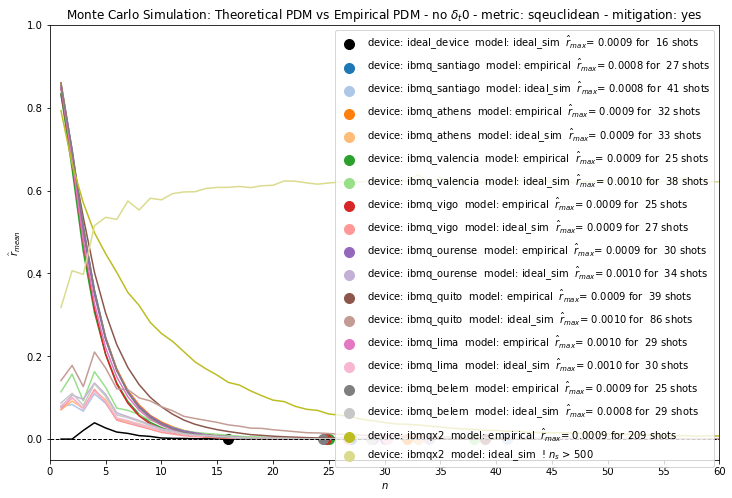

In [22]:
ADD=0+SAD+MIT
#opl.plot_curves(All_data, np.append(sm,ADD+np.array([4,5,12,13,20,21,28,29,36,37,44,45])),    
opl.plot_curves(All_data, np.append(sm,ADD+np.array([4,5,12,13,20,21,28,29,36,37,52,53,60,61,68,69,44,45])),                                                      
            "Monte Carlo Simulation: Theoretical PDM vs Empirical PDM - no $\delta_t0$",
            ["metric","mitigation"],
            ["device","model"], right_xlimit = 60)

#### Paired t-test and Wilcoxon test

In [23]:
for depvar in ['log_shots', 'log_min_r_shots']:
#for depvar in ['shots', 'min_r_shots']:
    print("mitigation:",mit,"  metric:",s_metric, "variable:", depvar)
    df_dep = df_mod.query("id_gates == 0.0 & device != 'ibmqx2'").groupby(['model'])[depvar]
    print(df_dep.describe(percentiles=[0.5]),"\n")
    # no error rate curve obtained for ibmqx2 with the ideal model, hence this exclusion:
    df_emp=df_mod.query("model == 'empirical' & device != 'ibmqx2' & id_gates == 0.0 ")
    df_ide=df_mod.query("model == 'ideal_sim' & device != 'ibmqx2' & id_gates == 0.0")  #.reindex_like(df_emp,'nearest')
    # back to numpy arrays from pandas: 
    print("paired data")
    print(np.asarray(df_emp[depvar]))
    print(np.asarray(df_ide[depvar]),"\n")
    
    print(stats.ttest_rel(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])))
    print(stats.wilcoxon(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])),"\n")

mitigation: yes   metric: sqeuclidean variable: log_shots
           count      mean       std       min       50%       max
model                                                             
empirical    8.0  3.356282  0.155304  3.218876  3.331566  3.663562
ideal_sim    8.0  3.611588  0.367515  3.295837  3.511434  4.454347 

paired data
[3.29583687 3.4657359  3.21887582 3.21887582 3.40119738 3.66356165
 3.36729583 3.21887582]
[3.71357207 3.49650756 3.63758616 3.29583687 3.52636052 4.4543473
 3.40119738 3.36729583] 

Ttest_relResult(statistic=-2.703455085610571, pvalue=0.03048624608052708)
WilcoxonResult(statistic=0.0, pvalue=0.0078125) 

mitigation: yes   metric: sqeuclidean variable: log_min_r_shots
           count      mean       std       min       50%       max
model                                                             
empirical    8.0  3.107878  0.155857  2.944439  3.091042  3.433987
ideal_sim    8.0  3.294950  0.332811  3.044522  3.178054  4.094345 

paired data
[3.0910

### Ideal vs empirical model: with state creation - measurements delay of 256  id gates

<Figure size 432x288 with 0 Axes>

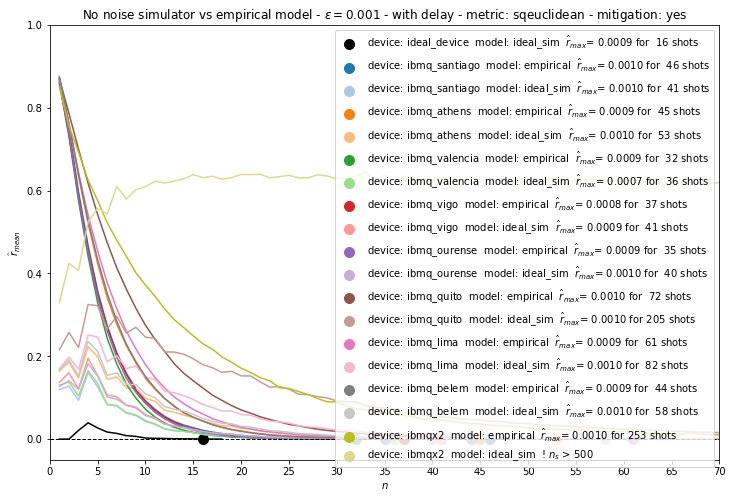

In [24]:
ADD=72+SAD+MIT
opl.plot_curves(All_data, np.append(sm,ADD+np.array([4,5,12,13,20,21,28,29,36,37,52,53,60,61,68,69,44,45])),                                                      
            "No noise simulator vs empirical model - $\epsilon=0.001$ - with delay",
            ["metric","mitigation"],
            ["device","model"], right_xlimit = 70)

#### Paired t-test and Wilcoxon test

In [25]:
for depvar in ['log_shots', 'log_min_r_shots']:
    print("mitigation:",mit,"  metric:",s_metric, "variable:", depvar)
    df_dep = df_mod.query("id_gates == 256.0 & device != 'ibmqx2' ").groupby(['model'])[depvar]
    print(df_dep.describe(percentiles=[0.5]),"\n")
    # no error rate curve obtained for ibmqx2   with the ideal model, hence their exclusion:
    df_emp=df_mod.query("model == 'empirical' & device != 'ibmqx2' & device != 'ibmq_quito' & id_gates == 256.0 ")
    df_ide=df_mod.query("model == 'ideal_sim' & device != 'ibmqx2' & device != 'ibmq_quito' & id_gates == 256.0")  #.reindex_like(df_emp,'nearest') 
    # back to numpy arrays from pandas: 
    print("paired data")
    print(np.asarray(df_emp[depvar]))
    print(np.asarray(df_ide[depvar]),"\n")
    
    print(stats.ttest_rel(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])))
    print(stats.wilcoxon(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])),"\n")

mitigation: yes   metric: sqeuclidean variable: log_shots
           count      mean       std       min       50%       max
model                                                             
empirical    8.0  3.804879  0.275711  3.465736  3.795426  4.276666
ideal_sim    8.0  4.057501  0.576714  3.583519  3.841932  5.323010 

paired data
[3.8286414  3.80666249 3.4657359  3.61091791 3.55534806 4.11087386
 3.78418963]
[3.71357207 3.97029191 3.58351894 3.71357207 3.68887945 4.40671925
 4.06044301] 

Ttest_relResult(statistic=-2.7157238790737805, pvalue=0.03484008351933883)
WilcoxonResult(statistic=2.0, pvalue=0.046875) 

mitigation: yes   metric: sqeuclidean variable: log_min_r_shots
           count      mean       std       min       50%       max
model                                                             
empirical    8.0  3.576911  0.271657  3.258097  3.540013  4.077537
ideal_sim    8.0  3.871177  0.556633  3.401197  3.702748  5.056246 

paired data
[3.49650756 3.63758616 3.258

### Pooling results obtained in circuit sets with and without creation-measurement delay

#### Paired t-test and Wilcoxon test

In [26]:
#for depvar in ['log_shots', 'log_min_r_shots']:
for depvar in ['log_shots', 'log_min_r_shots']:
    print("mitigation:",mit,"  metric:",s_metric, "variable:", depvar)
    df_dep = df_mod.query(" device != 'ibmqx2' & device != 'ibmq_quito' ").groupby(['model'])[depvar]
    print(df_dep.describe(percentiles=[0.5]),"\n")
    # no error rate curve obtained for ibmqx2 with the ideal model, hence this exclusion:
    df_emp=df_mod.query("model == 'empirical' & device != 'ibmqx2' & device != 'ibmq_quito' ")
    df_ide=df_mod.query("model == 'ideal_sim' & device != 'ibmqx2' & device != 'ibmq_quito' ")  #.reindex_like(df_emp,'nearest')
    # back to numpy arrays from pandas:
    print("paired data")
    print(np.asarray(df_emp[depvar]))
    print(np.asarray(df_ide[depvar]),"\n")
    
    print(stats.ttest_rel(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])))
    print(stats.wilcoxon(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])),"\n")

mitigation: yes   metric: sqeuclidean variable: log_shots
           count      mean       std       min       50%       max
model                                                             
empirical   14.0  3.524933  0.273318  3.218876  3.465736  4.110874
ideal_sim   14.0  3.683954  0.297664  3.295837  3.663233  4.406719 

paired data
[3.29583687 3.4657359  3.21887582 3.21887582 3.40119738 3.36729583
 3.21887582 3.8286414  3.80666249 3.4657359  3.61091791 3.55534806
 4.11087386 3.78418963]
[3.71357207 3.49650756 3.63758616 3.29583687 3.52636052 3.40119738
 3.36729583 3.71357207 3.97029191 3.58351894 3.71357207 3.68887945
 4.40671925 4.06044301] 

Ttest_relResult(statistic=-4.00028422947826, pvalue=0.0015112703302667153)
WilcoxonResult(statistic=5.0, pvalue=0.001220703125) 

mitigation: yes   metric: sqeuclidean variable: log_min_r_shots
           count      mean       std       min       50%       max
model                                                             
empirical   14

#### Statsmodel Ordinary Least Square (OLS)  Analysis

In [27]:
print("mitigation:",mit,"  metric:",s_metric )
stat_model = ols("log_shots ~  model + id_gates + device" ,# + id_gates +id_gates*model" , #"+ device + model*device + id_gates + model*id_gates",
                 df_mod.query(" device != 'ibmqx2' ")).fit() 
print(stat_model.summary())

mitigation: yes   metric: sqeuclidean
                            OLS Regression Results                            
Dep. Variable:              log_shots   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     9.865
Date:                Sun, 28 Feb 2021   Prob (F-statistic):           6.77e-06
Time:                        08:31:41   Log-Likelihood:                 7.0023
No. Observations:                  32   AIC:                             5.995
Df Residuals:                      22   BIC:                             20.65
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [28]:
print("mitigation:",mit,"  metric:",s_metric )
stat_model = ols("log_min_r_shots ~  model + id_gates ",
                 df_mod).fit() 
print(stat_model.summary())

mitigation: yes   metric: sqeuclidean
                            OLS Regression Results                            
Dep. Variable:        log_min_r_shots   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     3.809
Date:                Sun, 28 Feb 2021   Prob (F-statistic):             0.0332
Time:                        08:31:41   Log-Likelihood:                -25.518
No. Observations:                  34   AIC:                             57.04
Df Residuals:                      31   BIC:                             61.61
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

##### Comments:
The classical paired t-test and Wilcoxon test favour an advantage of the front end empirical model. 

The OLS model confirms the front end empirical model advantage on the ideal device model for what concerns $ln\;n_s$ and $ln\;n_t$.

##  2. Error rate vs quantum readout fidelity and quantum volume

### 2.1 correlation between $\ln \; n_s$ for $\epsilon$ = 0.001 and  quantum readout error fidelity
Only the case with mitigation is studied here, as the case without mitigation lack of the data concerning the Yorktown device.

#### A look at the error rate curves obtained using the front end empirical model

<Figure size 432x288 with 0 Axes>

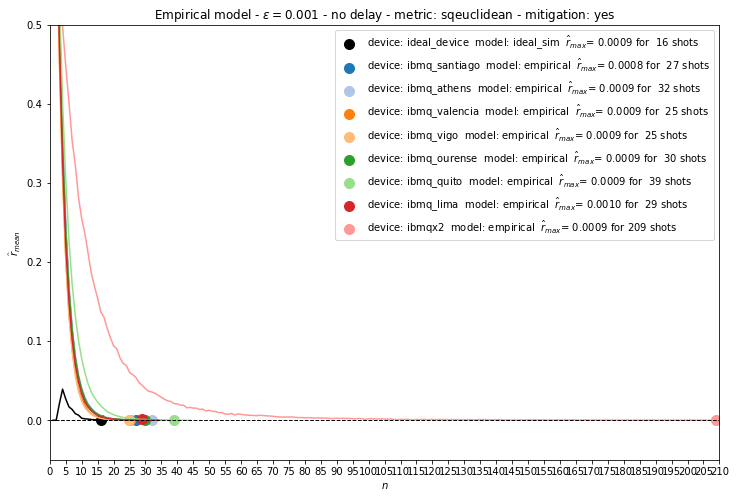

In [29]:
ADD=0+SAD+MIT
opl.plot_curves(All_data, np.append(sm,ADD+np.array([4,12,20,28,36,52,60,44])),                                                      
            "Empirical model - $\epsilon=0.001$ - no delay",
            ["metric","mitigation"],
            ["device","model"], right_xlimit = 210, top_ylimit = 0.5)

 #### Correlation  between $\ln \; n_s$ for $\epsilon$ = 0.001 and  quantum readout error fidelity

<Figure size 720x432 with 0 Axes>

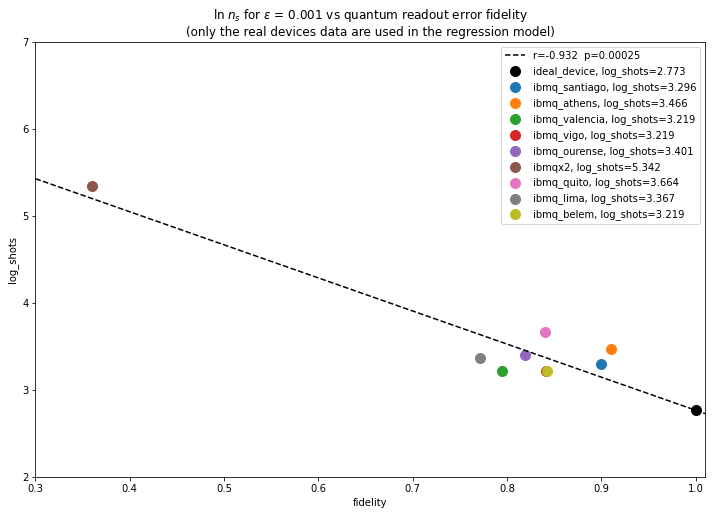

In [30]:
# rem: in this figure, the ideal device calculated value is shown
# but not included in the regression model
df_short = df_All.query("model == 'empirical' & id_gates == 0.0 " )
df_short = df_short[df_short.metric == s_metric]
# exclude ibmqx2 when no mitigation (no data)
if mit == "no":
    df_short = df_short[df_short.device != 'ibmqx2']
# here for adding the "ideal device" observation"
df_ideal= df_All.query("device == 'ideal_device' ")
df_ideal = df_ideal[df_ideal.metric == s_metric]  
df_short = df_short[df_short['mitigation']==mit]
tit_head = "$\ln \; n_s$ for $\epsilon$ = 0.001 vs "
tit_tail =  "(only the real devices data are used in the regression model)"
opl.plot_scatter(df_ideal.append(df_short),"fidelity",
     tit_head + "quantum readout error fidelity\n" +tit_tail, ydata='log_shots',
     left_xlimit = 0.1*np.floor(min(df_short.fidelity*10)), right_xlimit = 1.01,
     bottom_ylimit = np.floor(min(df_ideal.log_shots)),
     top_ylimit = 1+np.ceil(max(df_short.log_shots)))

In [31]:
print("mitigation:",mit,"  metric:",s_metric )
stat_model = ols("log_shots ~  fidelity",
                 df_mod.query("id_gates == 0.0 & model == 'empirical'")).fit() 
print(stat_model.summary())

mitigation: yes   metric: sqeuclidean
                            OLS Regression Results                            
Dep. Variable:              log_shots   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     46.53
Date:                Sun, 28 Feb 2021   Prob (F-statistic):           0.000248
Time:                        08:31:43   Log-Likelihood:                0.41458
No. Observations:                   9   AIC:                             3.171
Df Residuals:                       7   BIC:                             3.565
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

C:\Users\decpi\Anaconda3\envs\QK20\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [32]:
# check: show that python linregress (see figure) and OLS stat_model (table) agree
print("r calculated in the OLS model:", round(np.sqrt(stat_model.rsquared),3)) 
print("to be compared to the value of r reported in the figure legend")

r calculated in the OLS model: 0.932
to be compared to the value of r reported in the figure legend


#### calculate the expected value of n_s for a theoretical fidelity equal to 1.0 

In [33]:
# calculate the expected value of n_s for a theoretical fidelity equal to 1.0
# to be compared to the oracle derived value for an ideal device: n_s = 16  
id_fidelity = 1.0
alpha, beta = stat_model.params
n_ideal = np.exp(alpha+beta*id_fidelity)
print("extrapolated value of n_s at fidelity = 1.0:", n_ideal)
print("to be compared to the oracle derived value for an ideal device: n_s = 16")

extrapolated value of n_s at fidelity = 1.0: 15.883666767365996
to be compared to the oracle derived value for an ideal device: n_s = 16


#### Comments:

A significant correlation was found experimentally between $\ln \; n_s$ and $f$ in the case of applying MEM and the empirical model, with no delay introduced between state creation and measurement.
    
Interestingly, for this case the theoretical $n_s$ value for an ideal device and the $n_s$ value for $f$ = 1.0 extrapolated from the $\ln \; n_s$ - $f$ correlation are quiet similar (16 vs 15.9). 

This is however not observed in the case without mitigation.